In [1]:
import os
work_dir = '/penguin/hucy/Mandalay/lutan/test'
redo = True

os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /penguin/hucy/Mandalay/lutan/test


In [2]:
# #基于定位不准确的原因，手动调一下经纬度的偏移量
# from mintpy.utils import readfile
# from mintpy.utils import writefile
# fname_lat = 'lat.rdr.mli'
# out_file_lat = 'lat.rdr.mli'
# data_lat, atr_lat = readfile.read_binary_file(fname_lat, datasetName=None, box=None, xstep=1, ystep=1)
# data_lat = data_lat-0
# out_file_lat = writefile.write_binary(data_lat, out_file_lat, data_type=None, interleave='BIL')

# fname_lon = 'lon.rdr.mli'
# out_file_lon = 'lon.rdr.mli'
# data_lon, atr_lon = readfile.read_binary_file(fname_lon, datasetName=None, box=None, xstep=1, ystep=1)
# data_lon = data_lon+0.0385
# out_file_lon = writefile.write_binary(data_lon, out_file_lon, data_type=None, interleave='BIL')

In [3]:
%matplotlib inline

import numpy as np
import platform
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, view
from mintpy.view import prep_slice, plot_slice
plt.rcParams.update({'font.size': 12})

ds_name = ['LT1_A052_20240806_20250330_RG', 'LT1_A052_20240806_20250330_AZ'][0]
print(ds_name)

# grid
S, N, W, E = 20.5, 23.5, 95, 96.5   # same as Fig. 1;  36.0, 39.0, 35.8, 38.8
step = 0.000277778   # deg (~300 m)  # set to None to calculate product resolution for reference

# input files
off_file = os.path.join(work_dir, 'filt_denseOffsets.bil')
cov_file = os.path.join(work_dir, 'denseOffsets_cov.bil')
snr_file = os.path.join(work_dir, 'denseOffsets_snr.bil')
lat_file = os.path.join(work_dir, 'lat.rdr.mli')
lon_file = os.path.join(work_dir, 'lon.rdr.mli')
los_file = os.path.join(work_dir, 'los.rdr.mli')
hgt_file = os.path.join(work_dir, 'z.rdr.mli')  
msk_file = os.path.join(work_dir, 'waterMask.rdr') 
xml_file = os.path.join(work_dir, '../reference_slc.xml')
atr = readfile.read_attribute(off_file)

# output files
rdr_file = os.path.join(work_dir, 'offRg.h5' if ds_name.endswith('RG') else 'offAz.h5')

LT1_A052_20240806_20250330_RG


In [4]:
# utils functions
def read_offset():
    # calculate pixel_size (to convert offset unit from pixel to meters)
    meta = isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0]

    obs_dir = 'band2' if ds_name.endswith('RG') else 'band1'
    if obs_dir == 'band2':
        pixel_size = float(meta['RANGE_PIXEL_SIZE']) #row spacing
        # pixel_size = 1.41861959617637257 #row spacing
        print('Slant range pixel size: {:.2f} m'.format(pixel_size))
    else:
        Re, h_sat = float(meta['EARTH_RADIUS']), float(meta['HEIGHT'])
        pixel_size = float(meta['AZIMUTH_PIXEL_SIZE']) * Re / (Re + h_sat) #column spacing
        # pixel_size = 1.66551365555555564 #column spacing
        print('Ground azimuth pixel size: {:.2f} m'.format(pixel_size))

    # read data / attribute
    off = readfile.read(off_file, datasetName=f'{obs_dir}')[0] * pixel_size
    off_std = np.sqrt(readfile.read(cov_file, datasetName=f'{obs_dir}')[0]) * pixel_size
    off_snr = readfile.read(snr_file)[0]

    return off, off_std, off_snr


def mask_offset(off, off_std, off_snr, config):
    # 1. ignore no-data-value
    no_data_value = readfile.get_no_data_value(off_file)
    off[off == no_data_value] = np.nan
    print(f'# of pixels after removing no-data-value ({no_data_value}): {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 2. ignore water body
    water_mask = readfile.read(msk_file)[0]
    off[water_mask == 0] = np.nan
    off_std[water_mask == 0] = np.nan
    off_snr[water_mask == 0] = np.nan
    print(f'# of pixels after removing water body: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')
    off_raw = np.array(off, dtype=np.float32)

    # 3. remove pixels with abnormal offset
    off_std[np.isnan(off)] = np.nan
    off[np.abs(off) > config['max_off']] = np.nan
    print(f'# of pixels after removing offset > {config["max_off"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 4. remove pixels with low offset SNR
    off[np.isnan(off_snr)] = np.nan
    flag = off_snr < config['min_snr']    # remove pixels with low SNR value
    flag[np.abs(off / off_std) > 3] = 0   # keep   pixels with high off / off_std
    flag[off_snr < 1] = 1                 # remove pixels with very low SNR value
    off[flag] = np.nan
    print(f'# of pixels after removing SNR < {config["min_snr"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 5. remove pixels with high offset STD
    off_std[off_std > config['max_off']/2] = np.nan
    off[np.isnan(off_std)] = np.nan
    off[off_std > config['max_std']] = np.nan
    print(f'# of pixels after removing STD > {config["max_std"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    return off, off_std, off_snr, off_raw


def count(data):
    """Count the number of valid pixels"""
    return np.sum(~np.isnan(data))

print('warm up utils functions.')

warm up utils functions.


extract metadata from ISCE/stripmapStack shelve file: /penguin/hucy/Mandalay/lutan/test/../reference_slc.xml
Slant range pixel size: 1.67 m
# of pixels after removing no-data-value (None): 6147648 out of 6147648 (100.0%)
# of pixels after removing water body: 6064748 out of 6147648 (98.7%)
# of pixels after removing offset > 5: 3599921 out of 6147648 (58.6%)
# of pixels after removing SNR < 5: 3264160 out of 6147648 (53.1%)
# of pixels after removing STD > 0.4: 1949638 out of 6147648 (31.7%)
create HDF5 file: /penguin/hucy/Mandalay/lutan/test/offRg.h5 with w mode


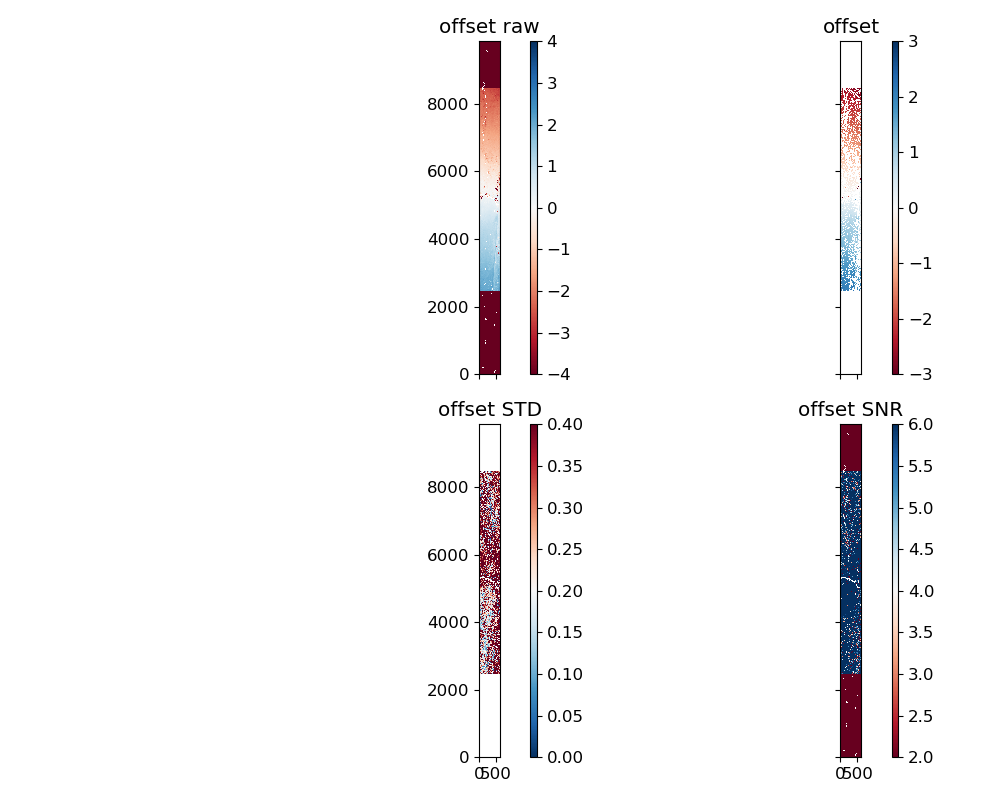

In [5]:
config = {
    'LT1_A052_20240806_20250330_RG': {'max_off': 5, 'min_snr': 5, 'max_std': 0.4},
    'LT1_A052_20240806_20250330_AZ': {'max_off': 4.8, 'min_snr': 8, 'max_std': 0.25},
}[ds_name]

# read and mask
off, off_std, off_snr = read_offset()
off, off_std, off_snr, off_raw = mask_offset(off, off_std, off_snr, config)

# write to one HDF5 files
atr['ORBIT_DIRECTION'] = 'ASCENDING' if ds_name.startswith('LT1_A') else 'DESCENDING'
if redo or not os.path.isfile(rdr_file):
    ds_dict      = {'displacement' : np.array(off, dtype=np.float32), 'displacementStd' : np.array(off_std, dtype=np.float32)}
    ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
    writefile.write(ds_dict, out_file=rdr_file, metadata=atr, ds_unit_dict=ds_unit_dict, compression='lzf', print_msg=False)

# plot
%matplotlib widget
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[10, 8], sharex=True, sharey=True)
for ax, data, [vmin, vmax], cmap, title in zip(axs.flatten(), [off_raw, off, off_std, off_snr], [[-4, 4], [-3, 3], [0, config['max_std']], [2, config['min_snr']+1]], ['RdBu', 'RdBu', 'RdBu_r', 'RdBu'], ['offset raw', 'offset', 'offset STD', 'offset SNR']):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest'); fig.colorbar(im, ax=ax, aspect=50); pp.auto_flip_direction(atr, ax, print_msg=False); ax.set_title(title)
fig.tight_layout()
plt.show()

In [6]:
if step is None:
    iw_xml_file = os.path.join(proj_dir, ds_name, 'referencedir/IW1.xml')
    meta = isce_utils.extract_isce_metadata(iw_xml_file)[0]
    meta['WIDTH'] = int(atr['WIDTH']) * 64
    ystep_m = ut.azimuth_ground_resolution(meta) * 32;  ystep_d = ystep_m / 108e3
    xstep_m = ut.range_ground_resolution(meta) * 64;    xstep_d = xstep_m / (108e3 * np.cos(np.deg2rad(37)))
    print(f'y/x step: {ystep_m:.1f} / {xstep_m:.1f} m; {ystep_d:.4f}, {xstep_d:.4f} deg')

geocode.py /penguin/hucy/Mandalay/lutan/test/offRg.h5 --dset displacement -o /penguin/hucy/Mandalay/lutan/test/offRgramp.geo --lat-file /penguin/hucy/Mandalay/lutan/test/lat.rdr.mli --lon-file /penguin/hucy/Mandalay/lutan/test/lon.rdr.mli --fill nan --bbox 20.5 23.5 95 96.5 --lalo -0.000277778 0.000277778
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /penguin/hucy/Mandalay/lutan/test/lat.rdr.mli
output pixel size in (lat, lon) in degree: (-0.000277778, 0.000277778)
output area extent in (S, N, W, E) in degree: (20.4999976, 23.5, 95.0, 96.5000012)
output file row / column number: (10800, 5400)
[1/1] preparing geometry for dest_box: (0, 0, 5400, 10800) --> full src_box: (0, 0, 624, 9852)
--------------------------------------------------
resampling file: /penguin/hucy/Mandalay/lutan/test/offRg.h5
--------------------------------------------------1/1
reading displacement in block (0, 0, 624, 9852) from offRg.h5 ...
near

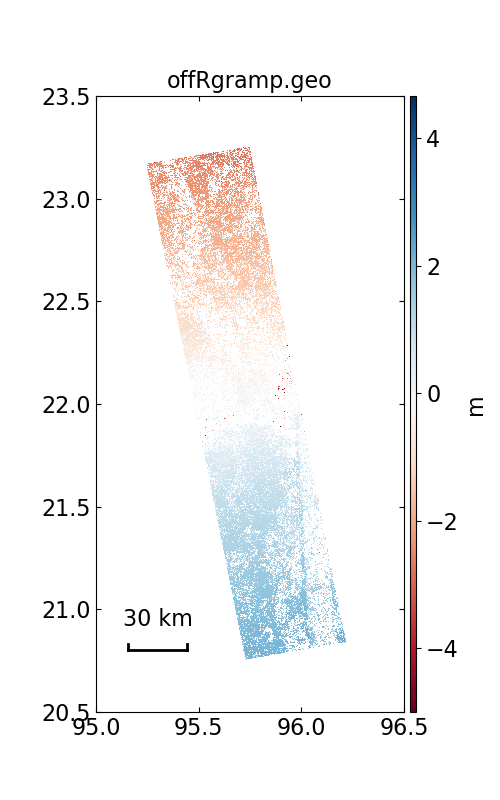

In [7]:
opt = f'--lat-file {lat_file} --lon-file {lon_file} --fill nan --bbox {S} {N} {W} {E} --lalo -{step} {step}'
fbase = os.path.splitext(rdr_file)[0]
io_files = [
    [rdr_file, '--dset displacement',    f'{fbase}ramp.geo'],      # offset
    [rdr_file, '--dset displacementStd', f'{fbase}Std.geo'],   # offset STD
    [los_file, '', os.path.join(work_dir, 'los.geo')]          # offset geometry
]
for ifile, dset, ofile in io_files:
    if redo or not os.path.isfile(ofile):
        cmd = f'{ifile} {dset} -o {ofile} {opt}'
        print(f'geocode.py {cmd}')
        geocode.main(cmd.split())

# plot
view.main(f'{fbase}ramp.geo -c RdBu --noverbose'.split())

In [8]:
from mintpy.cli import load_data, smallbaselineApp
# write geometry HDF5 file
config = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = {os.path.join(work_dir, '../reference_slc.xml')}
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = {hgt_file}
mintpy.load.lookupYFile      = {lat_file}
mintpy.load.lookupXFile      = {lon_file}
mintpy.load.incAngleFile     = {los_file}
mintpy.load.azAngleFile      = {los_file}
mintpy.load.waterMaskFile    = {msk_file}
"""

sname, oname = ds_name.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())
# write geometryGeo.h5
geocode.main(f'./inputs/geometryRadar.h5 -o ./inputs/geometryGeo.h5 {opt}'.split())

write MintPy configuration to file: /penguin/hucy/Mandalay/lutan/test/LT1_A052.txt
--------------------------------------------------
Project name: LT1_A052
Go to work directory: /penguin/hucy/Mandalay/lutan/test
read custom template file: /penguin/hucy/Mandalay/lutan/test/LT1_A052.txt
update default template based on input custom template
No new option value found, skip updating /penguin/hucy/Mandalay/lutan/test/smallbaselineApp.cfg
copy LT1_A052.txt         to inputs   directory for backup.
copy LT1_A052.txt         to pic      directory for backup.
read default template file: /penguin/hucy/Mandalay/lutan/test/smallbaselineApp.cfg
Go back to directory: /penguin/hucy/Mandalay/lutan/test

################################################
   Normal end of smallbaselineApp processing!
################################################
Time used: 00 mins 0.0 secs

processor : isce
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepar

/home/hucy/tools/MintPy/src/mintpy/load_data.py:711: UserWarning: prep_isce.py failed. Assuming its result exists and continue...
  warnings.warn('prep_isce.py failed. Assuming its result exists and continue...')


All datasets exists in file geometryRadar.h5 with same size as required, no need to re-load.
time used: 00 mins 0.1 secs.

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /penguin/hucy/Mandalay/lutan/test/lat.rdr.mli
output pixel size in (lat, lon) in degree: (-0.000277778, 0.000277778)
output area extent in (S, N, W, E) in degree: (20.4999976, 23.5, 95.0, 96.5000012)
output file row / column number: (10800, 5400)
[1/1] preparing geometry for dest_box: (0, 0, 5400, 10800) --> full src_box: (0, 0, 624, 9852)
--------------------------------------------------
resampling file: ./inputs/geometryRadar.h5
--------------------------------------------------
grab dataset structure from ref_file: ./inputs/geometryRadar.h5
create HDF5 file: ./inputs/geometryGeo.h5 with w mode
create dataset  : azimuthAngle       of float32                   in size of (10800, 5400)        with compression = lzf
create dataset  : height           

In [9]:
# add some metadata
meta = readfile.read_roipac_rsc(f'../data.rsc')
atr0 = readfile.read_attribute(f'{fbase}ramp.geo')
for key in atr0.keys():
    if key in meta.keys():
        meta.pop(key)
meta['DATE12'] = ptime.yymmdd_date12(ptime.get_date12_from_path(ds_name))
meta['FILE_TYPE'] = 'displacement'
ut.add_attribute(f'{fbase}ramp.geo', meta, print_msg=True)

add/update ALOOKS = 1
add/update ANTENNA_SIDE = -1
add/update AZIMUTH_PIXEL_SIZE = 1.5570981703616593
add/update CENTER_INCIDENCE_ANGLE = nan
add/update CENTER_LINE_UTC = 42115.0
add/update EARTH_RADIUS = 6345206.479158109
add/update HEADING = -11.887719197180745
add/update HEIGHT = 605466.0782959105
add/update NCORRLOOKS = 0.2824667882742239
add/update PLATFORM = lt1b
add/update POLARIZATION = HH
add/update PRF = 4907.975586
add/update RANGE_PIXEL_SIZE = 1.6655136555555556
add/update RLOOKS = 1
add/update STARTING_RANGE = 742874.7111765259
add/update WAVELENGTH = 0.23793052222222222
add/update altitude = 605466.0782959105
add/update azimuthPixelSize = 1.5570981703616593
add/update azimuthResolution = 4.9
add/update beam_mode = SM
add/update earthRadius = 6345206.479158109
add/update polarization = HH
add/update prf = 4907.975586
add/update radarWavelength = 0.23793052222222222
add/update rangePixelSize = 1.6655136555555556
add/update rangeResolution = 1.8737028625
add/update satellite

'/penguin/hucy/Mandalay/lutan/test/offRgramp.geo'

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce displacement file: /penguin/hucy/Mandalay/lutan/test/offRgramp.geo in float32 format
file size in y/x: (10800, 5400)
num of datasets in file offRgramp.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 5400, 10800)
subset coverage in y/x: (0, 0, 5400, 10800)
data   coverage in lat/lon: (95.0, 23.5, 96.5000012, 20.4999976)
subset coverage in lat/lon: (95.0, 23.5, 96.5000012, 20.4999976)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: LT1_A052_20240806_20250330_RG
figure size : [5.0, 8.0]
reading data ...
data    range: [-4.996541, 4.6582336] m
display range: [-4.0, 4.0] m
reading DEM: elevation_mli.dem ...
display data in transparency: 0.8
plot in geo-coordinate
plotting DEM background ...
show shaded relief 

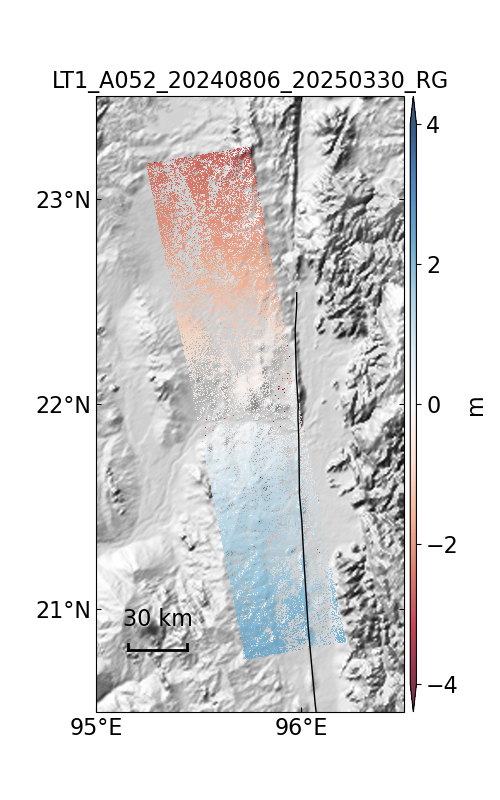

In [10]:
dis_file = f'{fbase}ramp.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{ds_name}_ramp.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
cmd += f'-c RdBu -v -4 4 --lalo-label --lalo-step 1 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name} '
cmd += f'-o {out_file} '
view.main(cmd.split())

In [11]:
opt = '' if ds_name.endswith('RG') else '-s quadratic_azimuth'
!remove_ramp.py {fbase}ramp.geo -m mask_deramp.h5 -o {fbase}.geo {opt}

remove linear ramp from file: /penguin/hucy/Mandalay/lutan/test/offRgramp.geo
read mask file: mask_deramp.h5
writing >>> /penguin/hucy/Mandalay/lutan/test/offRg.geo
write file: /penguin/hucy/Mandalay/lutan/test/offRg.geo
write file: /penguin/hucy/Mandalay/lutan/test/offRg.geo.rsc
add/update the following metadata to file:
add/update mintpy.deramp = linear
add/update mintpy.deramp.maskFile = mask_deramp.h5
write file: /penguin/hucy/Mandalay/lutan/test/offRg.geo.rsc
time used: 00 mins 3.1 secs.


view.py /penguin/hucy/Mandalay/lutan/test/offRg.geo -c RdBu -v -4 4 --noverbose


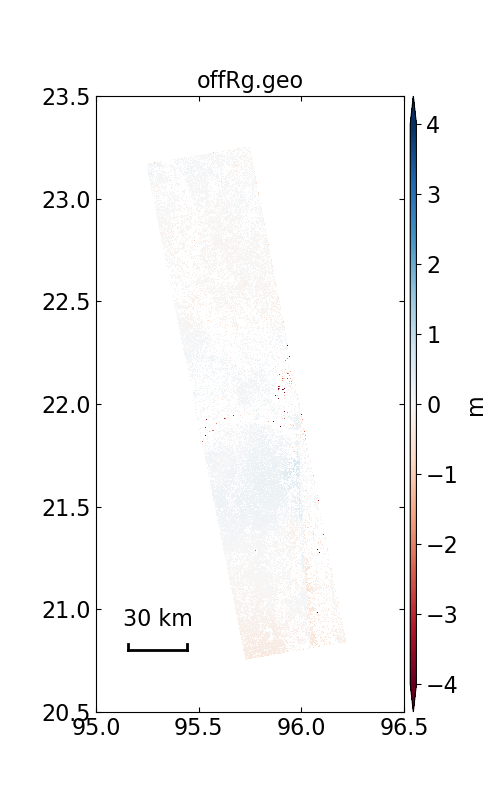

In [12]:
# plot
view.main(f'{fbase}.geo -c RdBu -v -4 4 --noverbose'.split())

view.py /penguin/hucy/Mandalay/lutan/test/offRgStd.geo -c RdBu_r -v 0 0.5 --noverbose


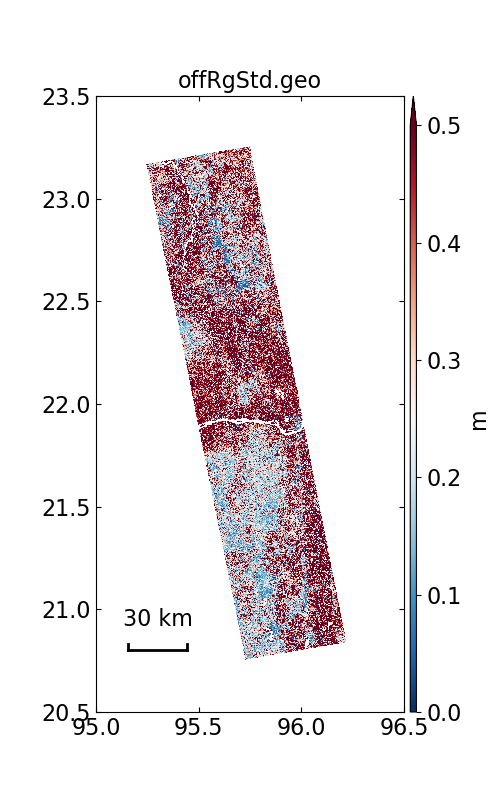

In [13]:
view.main(f'{fbase}Std.geo -c RdBu_r -v 0 0.5 --noverbose'.split())

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce displacement file: /penguin/hucy/Mandalay/lutan/test/offRg.geo in float32 format
file size in y/x: (10800, 5400)
num of datasets in file offRg.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 5400, 10800)
subset coverage in y/x: (0, 0, 5400, 10800)
data   coverage in lat/lon: (95.0, 23.5, 96.5000012, 20.4999976)
subset coverage in lat/lon: (95.0, 23.5, 96.5000012, 20.4999976)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: LT1_A052_20240806_20250330_RG
figure size : [5.0, 8.0]
reading data ...
data    range: [-7.274063, 4.6462083] m
display range: [-1.0, 1.0] m
reading DEM: elevation_mli.dem ...
display data in transparency: 0.8
plot in geo-coordinate
plotting DEM background ...
show shaded relief DEM (min

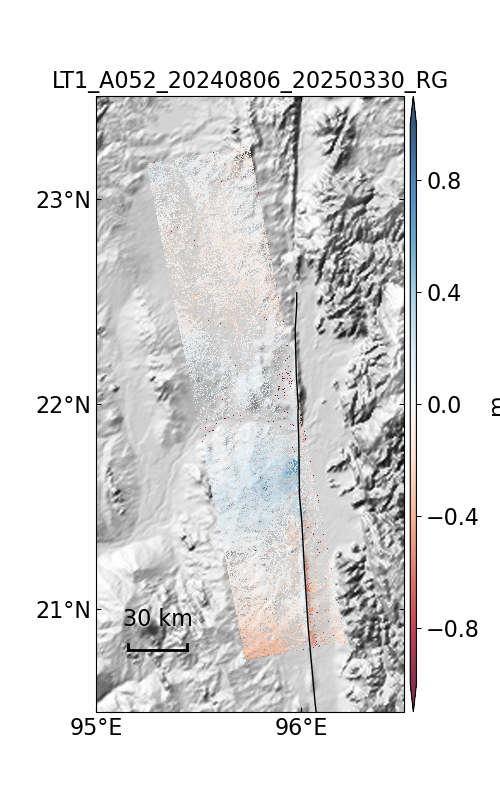

In [14]:
dis_file = f'{fbase}.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{ds_name}.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
opt = '-1 1' if ds_name.endswith('RG') else '-4 4'
cmd += f'-c RdBu -v {opt} --lalo-label --lalo-step 1 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name} '
cmd += f'-o {out_file} '
view.main(cmd.split())

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from mintpy.utils import readfile

def plot_column_row(data, col=150, row=7000):
    """Plot specific column and row of an image as scatter plot
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input 2D array
    col : int
        Column number to plot (default: 150)
    row : int
        Row number to plot (default: 7000)
    """
    # Get image dimensions
    length, width = data.shape
    
    # Check if requested column and row are within bounds
    if col >= width:
        raise ValueError(f'Column {col} is out of bounds. Image width is {width}')
    if row >= length:
        raise ValueError(f'Row {row} is out of bounds. Image length is {length}')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot column as scatter
    ax1.scatter(range(length), data[:, col], s=5, c='b', alpha=0.5)
    ax1.set_title(f'Column {col}')
    ax1.set_xlabel('Row')
    ax1.set_ylabel('Value')
    ax1.grid(True)
    
    # Plot row as scatter
    ax2.scatter(range(width), data[row, :], s=5, c='r', alpha=0.5)
    ax2.set_title(f'Row {row}')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Value')
    ax2.grid(True)
    
    # Adjust layout and show
    plt.tight_layout()
    plt.savefig(f'{fbase}slice.png')
    plt.show()

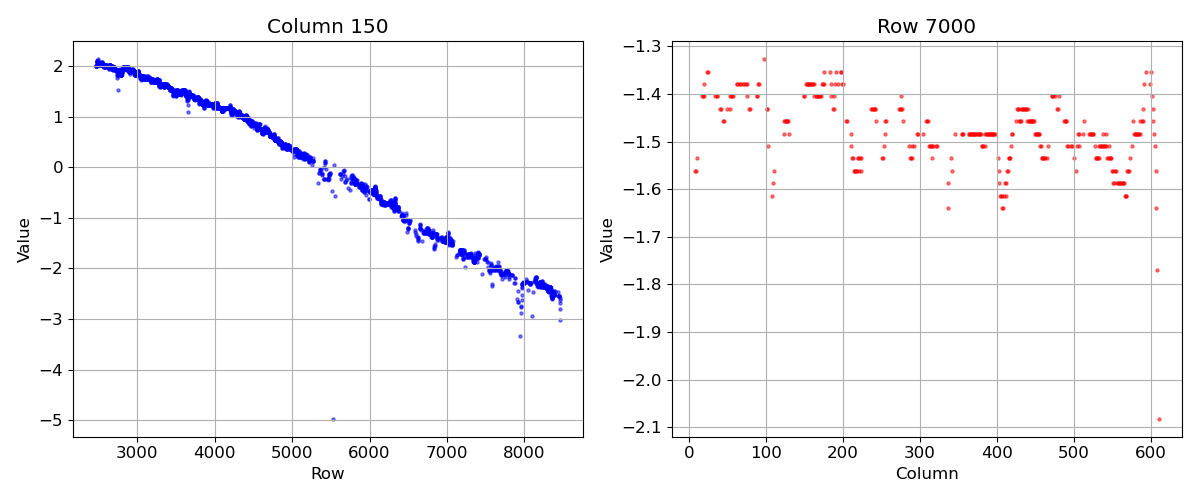

In [16]:
plot_column_row(off)

write file: /penguin/hucy/Mandalay/lutan/test/offRgRAMP.geo
write file: /penguin/hucy/Mandalay/lutan/test/offRgRAMP.geo.rsc
view.py /penguin/hucy/Mandalay/lutan/test/offRgRAMP.geo -c RdBu -v -5 5 --noverbose --save


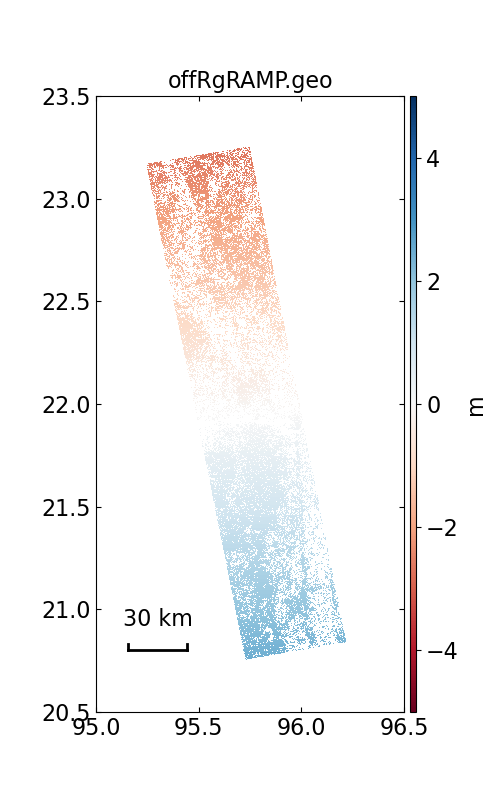

In [17]:
ramp = readfile.read(f'{fbase}ramp.geo')[0] - readfile.read(f'{fbase}.geo')[0]
atr = readfile.read_attribute(f'{fbase}.geo')
ramp_file = writefile.write(ramp, out_file=f'{fbase}RAMP.geo', metadata=atr)
view.main(f'{fbase}RAMP.geo -c RdBu -v -5 5 --noverbose --save'.split())